# Email Classification

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the datasets
train_df = pd.read_csv('SMS_train.csv',encoding='latin1')
test_df = pd.read_csv('SMS_test.csv',encoding='latin1')

In [3]:
train_df.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam


In [4]:
test_df.head()

,S. No.,Message_body,Label
0,1,"UpgrdCentre Orange customer, you may now claim...",Spam
1,2,"Loan for any purpose £500 - £75,000. Homeowner...",Spam
2,3,Congrats! Nokia 3650 video camera phone is you...,Spam
3,4,URGENT! Your Mobile number has been awarded wi...,Spam
4,5,Someone has contacted our dating service and e...,Spam


In [5]:
train_df.shape

(957, 3)

In [6]:
test_df.shape

(125, 3)

There are 957 records in training data and 125 in test data

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        957 non-null    int64 
 1   Message_body  957 non-null    object
 2   Label         957 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


In [8]:
train_df.isnull().sum()

S. No.          0
Message_body    0
Label           0
dtype: int64

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        125 non-null    int64 
 1   Message_body  125 non-null    object
 2   Label         125 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


In [10]:
test_df.isnull().sum()

S. No.          0
Message_body    0
Label           0
dtype: int64

In [11]:
test_df.drop('Label',axis=1,inplace=True)

In [12]:
test_df.head()

,S. No.,Message_body
0,1,"UpgrdCentre Orange customer, you may now claim..."
1,2,"Loan for any purpose £500 - £75,000. Homeowner..."
2,3,Congrats! Nokia 3650 video camera phone is you...
3,4,URGENT! Your Mobile number has been awarded wi...
4,5,Someone has contacted our dating service and e...


In [13]:
train_df.drop('S. No.',axis=1,inplace=True)

In [14]:
train_df.head()

,Message_body,Label
0,Rofl. Its true to its name,Non-Spam
1,The guy did some bitching but I acted like i'd...,Non-Spam
2,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,Will ü b going to esplanade fr home?,Non-Spam
4,This is the 2nd time we have tried 2 contact u...,Spam


In [15]:
nlp = spacy.load('en_core_web_sm')

In [16]:
def lower_replace(series):
    output = series.str.lower()
    output = output.str.replace(r'\[.*?\]', '', regex=True)
    output = output.str.replace(r'[^\w\s]', '', regex=True)
    return output

In [17]:
def lemma_stopwords(text):
    doc = nlp(text)
    output = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(output)

In [18]:
def clean_normalize(text):
    output = lower_replace(text)
    output = output.apply(lemma_stopwords)
    return output

In [19]:
train_df.rename({'Message_body':'Message'},axis=1,inplace=True)

In [20]:
test_df.rename({'Message_body':'Message'},axis=1,inplace=True)

In [21]:
train_df.head()

,Message,Label
0,Rofl. Its true to its name,Non-Spam
1,The guy did some bitching but I acted like i'd...,Non-Spam
2,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,Will ü b going to esplanade fr home?,Non-Spam
4,This is the 2nd time we have tried 2 contact u...,Spam


In [22]:
test_df.head()

,S. No.,Message
0,1,"UpgrdCentre Orange customer, you may now claim..."
1,2,"Loan for any purpose £500 - £75,000. Homeowner..."
2,3,Congrats! Nokia 3650 video camera phone is you...
3,4,URGENT! Your Mobile number has been awarded wi...
4,5,Someone has contacted our dating service and e...


In [23]:
train_df['Clean_Message'] = clean_normalize(train_df['Message'])

In [24]:
train_df.head()

,Message,Label,Clean_Message
0,Rofl. Its true to its name,Non-Spam,rofl true
1,The guy did some bitching but I acted like i'd...,Non-Spam,guy bitching act like d interested buy week gi...
2,"Pity, * was in mood for that. So...any other s...",Non-Spam,pity mood soany suggestion
3,Will ü b going to esplanade fr home?,Non-Spam,ü b go esplanade fr home
4,This is the 2nd time we have tried 2 contact u...,Spam,2nd time try 2 contact u u win 750 pound prize...


In [25]:
test_df['Clean_Message'] = clean_normalize(test_df['Message'])

In [26]:
test_df.head()

,S. No.,Message,Clean_Message
0,1,"UpgrdCentre Orange customer, you may now claim...",upgrdcentre orange customer claim free camera ...
1,2,"Loan for any purpose £500 - £75,000. Homeowner...",loan purpose 500 75000 homeowner tenant we...
2,3,Congrats! Nokia 3650 video camera phone is you...,congrats nokia 3650 video camera phone 0906638...
3,4,URGENT! Your Mobile number has been awarded wi...,urgent mobile number award 2000 prize guarante...
4,5,Someone has contacted our dating service and e...,contact date service enter phone fancy find la...


In [27]:
cv = CountVectorizer(stop_words='english',min_df=0.01,max_df=0.9)
X = cv.fit_transform(train_df['Clean_Message'])
X_df = pd.DataFrame(X.toarray(),columns=cv.get_feature_names_out())
X_df

,account,amp,ask,award,babe,bad,buy,care,cash,claim,...,watch,way,week,win,wish,work,yeah,year,yes,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
cv = CountVectorizer(stop_words='english',min_df=0.01,max_df=0.9)
X_test = cv.fit_transform(test_df['Clean_Message'])
X_test_df = pd.DataFrame(X_test.toarray(),columns=cv.get_feature_names_out())
X_test_df

,0800,08000839402,08000930705,0845,100,1000,11,11mth,125gift,12hrs,...,win,winner,wkly,word,world,wwwldewcom1win150ppmx3age16,xxx,ya,year,yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
lr = LogisticRegression()

In [30]:
train_df['Label'].value_counts(normalize=True).mul(100)

Label
Non-Spam    87.251829
Spam        12.748171
Name: proportion, dtype: float64

In [31]:
Y = train_df['Label']

In [32]:
X_train, X_val, Y_train, Y_val = train_test_split(X_df,Y,test_size=0.2,random_state=42,stratify=Y)

In [33]:
smote = SMOTE(random_state=42)

In [34]:
X_train_resample, Y_train_resample = smote.fit_resample(X_train,Y_train)

In [35]:
c = StratifiedKFold(n_splits=4,shuffle=True)

In [36]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1','l2'],
    'solver': ['lbfgs', 'liblinear','saga'],
    'class_weight': ['balanced']
}

In [37]:
model_lr = GridSearchCV(estimator=lr,param_grid=param_grid,cv=c,scoring='accuracy',verbose=2)

In [38]:
model_lr.fit(X_train_resample,Y_train_resample)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time

,estimator,LogisticRegression()
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': ['balanced'], 'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear', ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [39]:
model_lr.score(X_val,Y_val)

0.78125

In [40]:
model_lr.score(X_train,Y_train)

0.8052287581699347

In [41]:
model_lr.best_params_

{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

In [42]:
tf = TfidfVectorizer(stop_words='english',ngram_range=(1,2),min_df=0.01,max_df=0.9)
Xt = tf.fit_transform(train_df['Clean_Message'])
Xt_df = pd.DataFrame(Xt.toarray(),columns=tf.get_feature_names_out())
Xt_df

,account,amp,ask,award,babe,bad,buy,care,cash,claim,...,watch,way,week,win,wish,work,yeah,year,yes,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.493561,0.0,0.0,0.000000,...,0.0,0.0,0.437303,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.407952,...,0.0,0.0,0.000000,0.400516,0.0,0.00000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
953,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
954,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.56177,0.0,0.0,0.0,0.0
955,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0


In [43]:
X_train, X_val, Y_train, Y_val = train_test_split(Xt_df,Y,test_size=0.2,random_state=42,stratify=Y)

In [44]:
X_train_resample, Y_train_resample = smote.fit_resample(X_train,Y_train)

In [45]:
model_lr = GridSearchCV(estimator=lr,param_grid=param_grid,cv=c,scoring='accuracy',verbose=2)

In [46]:
model_lr.fit(X_train_resample,Y_train_resample)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time

,estimator,LogisticRegression()
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': ['balanced'], 'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear', ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [47]:
model_lr.score(X_val,Y_val)

0.9114583333333334

In [48]:
model_lr.score(X_train,Y_train)

0.9790849673202614

In [49]:
yhat = model_lr.predict(X_val)

In [50]:
accuracy_score(Y_val,yhat)

0.9114583333333334

In [51]:
print(classification_report(Y_val,yhat))

              precision    recall  f1-score   support

    Non-Spam       0.98      0.92      0.95       168
        Spam       0.60      0.88      0.71        24

    accuracy                           0.91       192
   macro avg       0.79      0.90      0.83       192
weighted avg       0.93      0.91      0.92       192



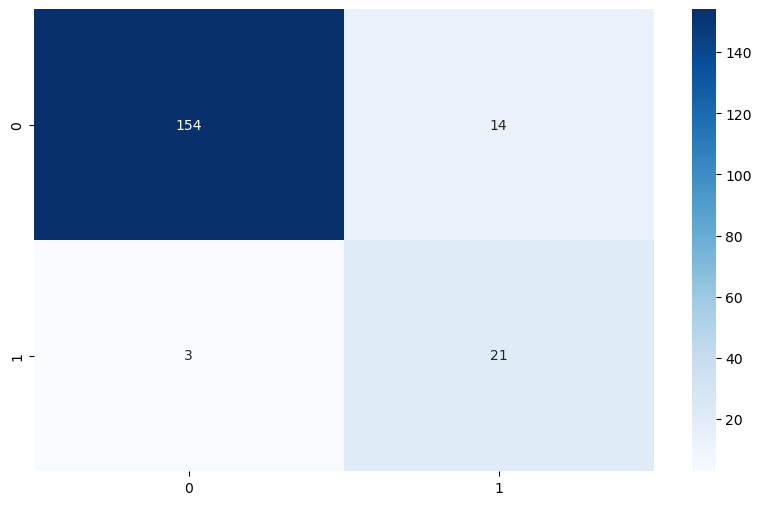

In [52]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(Y_val,yhat),annot=True,fmt='d',cmap='Blues')
plt.show()

In [53]:
X_test_t = tf.transform(test_df['Clean_Message'])
ypred = model_lr.predict(X_test_t)

In [55]:
test_lr_df = pd.DataFrame(
    {
        'Message':test_df['Message'],
        'Predicted Labels':ypred
    }
)

In [56]:
test_lr_df.head(10)

,Message,Predicted Labels
0,"UpgrdCentre Orange customer, you may now claim...",Spam
1,"Loan for any purpose £500 - £75,000. Homeowner...",Spam
2,Congrats! Nokia 3650 video camera phone is you...,Spam
3,URGENT! Your Mobile number has been awarded wi...,Spam
4,Someone has contacted our dating service and e...,Spam
5,Send a logo 2 ur lover - 2 names joined by a h...,Non-Spam
6,FREE entry into our £250 weekly competition ju...,Spam
7,100 dating service cal;l 09064012103 box334sk38ch,Spam
8,FREE RINGTONE text FIRST to 87131 for a poly o...,Spam
9,4mths half price Orange line rental & latest c...,Spam


In [58]:
analyzer = SentimentIntensityAnalyzer()

def sentiments(text):
    return analyzer.polarity_scores(text)['compound']

In [59]:
test_lr_df['Sentiments'] = test_lr_df['Message'].apply(sentiments)

In [60]:
test_lr_df.head(10)

,Message,Predicted Labels,Sentiments
0,"UpgrdCentre Orange customer, you may now claim...",Spam,0.8192
1,"Loan for any purpose £500 - £75,000. Homeowner...",Spam,0.8591
2,Congrats! Nokia 3650 video camera phone is you...,Spam,0.5707
3,URGENT! Your Mobile number has been awarded wi...,Spam,0.8452
4,Someone has contacted our dating service and e...,Spam,0.0000
5,Send a logo 2 ur lover - 2 names joined by a h...,Non-Spam,0.9581
6,FREE entry into our £250 weekly competition ju...,Spam,0.8613
7,100 dating service cal;l 09064012103 box334sk38ch,Spam,0.0000
8,FREE RINGTONE text FIRST to 87131 for a poly o...,Spam,0.8984
9,4mths half price Orange line rental & latest c...,Spam,0.8236


In [61]:
test_lr_df.shape

(125, 3)

In [63]:
test_lr_df.to_csv('Logistic_Regression_Test.csv')

### Logistic Regression with TF-IDF Vectorizer
- Accuracy: 91%
- Precision
  1. Non-Spam: 98%
  2. Spam: 60%
- Recall
  1. Non-Spam: 92%
  2. Spam: 88%

In [64]:
nb = MultinomialNB()

In [65]:
nb.fit(X_train_resample,Y_train_resample)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [66]:
nb.score(X_val,Y_val)

0.9166666666666666

In [67]:
nb.score(X_train_resample,Y_train_resample)

0.9460269865067467

In [68]:
yhat = nb.predict(X_val)

In [69]:
accuracy_score(Y_val,yhat)

0.9166666666666666

In [70]:
print(classification_report(Y_val,yhat))

              precision    recall  f1-score   support

    Non-Spam       0.99      0.91      0.95       168
        Spam       0.61      0.96      0.74        24

    accuracy                           0.92       192
   macro avg       0.80      0.93      0.85       192
weighted avg       0.94      0.92      0.92       192



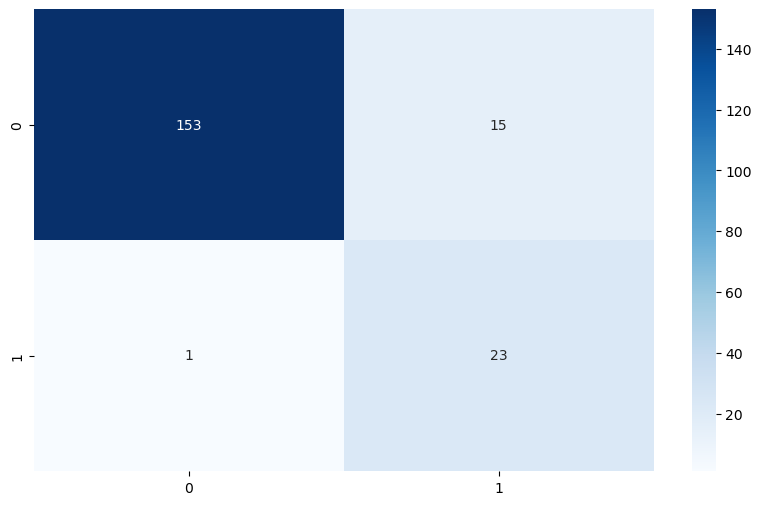

In [71]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(Y_val,yhat),annot=True,fmt='d',cmap='Blues')
plt.show()

In [72]:
X_test_t = tf.transform(test_df['Clean_Message'])
ypred = nb.predict(X_test_t)

In [73]:
test_nb_df = pd.DataFrame(
    {
        'Message':test_df['Message'],
        'Predicted Labels':ypred
    }
)

In [74]:
test_nb_df['Sentiments'] = test_nb_df['Message'].apply(sentiments)

In [75]:
test_nb_df.head(10)

,Message,Predicted Labels,Sentiments
0,"UpgrdCentre Orange customer, you may now claim...",Spam,0.8192
1,"Loan for any purpose £500 - £75,000. Homeowner...",Spam,0.8591
2,Congrats! Nokia 3650 video camera phone is you...,Spam,0.5707
3,URGENT! Your Mobile number has been awarded wi...,Spam,0.8452
4,Someone has contacted our dating service and e...,Spam,0.0000
5,Send a logo 2 ur lover - 2 names joined by a h...,Non-Spam,0.9581
6,FREE entry into our £250 weekly competition ju...,Spam,0.8613
7,100 dating service cal;l 09064012103 box334sk38ch,Spam,0.0000
8,FREE RINGTONE text FIRST to 87131 for a poly o...,Spam,0.8984
9,4mths half price Orange line rental & latest c...,Spam,0.8236


In [76]:
test_nb_df.to_csv('Naive_Bayes_Test.csv')

### Naive Bayes with TF-IDF Vectorizer
- Accuracy: 91%
- Precision
  1. Non-Spam: 99%
  2. Spam: 61%
- Recall
  1. Non-Spam: 91%
  2. Spam: 96%

In [77]:
rf = RandomForestClassifier(random_state=42)

In [78]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

In [79]:
model_rf = GridSearchCV(estimator=rf,param_grid=param_grid,cv=c,scoring='accuracy',verbose=2)
model_rf.fit(X_train_resample,Y_train_resample)

Fitting 4 folds for each of 162 candidates, totalling 648 fits
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_le

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'class_weight': ['balanced'], 'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [80]:
model_rf.score(X_val,Y_val)

0.921875

In [81]:
model_rf.score(X_train_resample,Y_train_resample)

0.9835082458770614

In [82]:
yhat = model_rf.predict(X_val)

In [83]:
accuracy_score(Y_val,yhat)

0.921875

In [84]:
print(classification_report(Y_val,yhat))

              precision    recall  f1-score   support

    Non-Spam       0.98      0.93      0.95       168
        Spam       0.65      0.83      0.73        24

    accuracy                           0.92       192
   macro avg       0.81      0.88      0.84       192
weighted avg       0.93      0.92      0.93       192



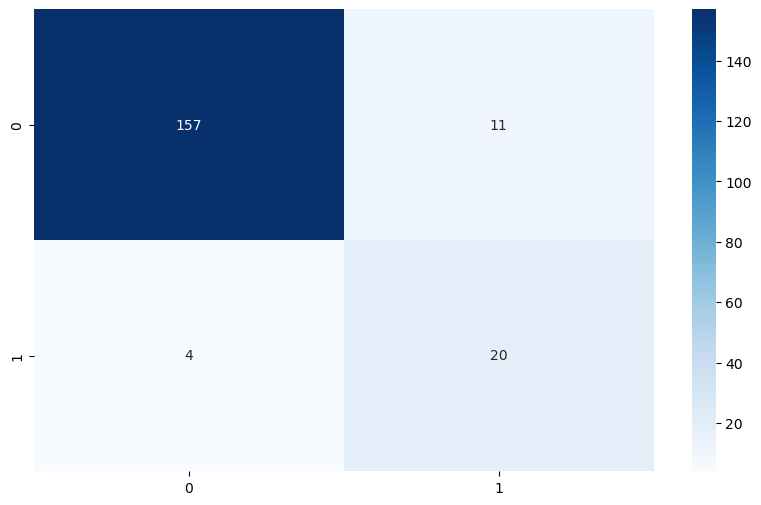

In [85]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(Y_val,yhat),annot=True,fmt='d',cmap='Blues')
plt.show()

In [86]:
X_test_t = tf.transform(test_df['Clean_Message'])
ypred = model_rf.predict(X_test_t)

In [88]:
test_rf_df = pd.DataFrame(
    {
        'Message':test_df['Message'],
        'Predicted Labels':ypred
    }
)

In [89]:
test_rf_df['Sentiments'] = test_rf_df['Message'].apply(sentiments)

In [90]:
test_rf_df.head(10)

,Message,Predicted Labels,Sentiments
0,"UpgrdCentre Orange customer, you may now claim...",Spam,0.8192
1,"Loan for any purpose £500 - £75,000. Homeowner...",Spam,0.8591
2,Congrats! Nokia 3650 video camera phone is you...,Spam,0.5707
3,URGENT! Your Mobile number has been awarded wi...,Spam,0.8452
4,Someone has contacted our dating service and e...,Spam,0.0000
5,Send a logo 2 ur lover - 2 names joined by a h...,Spam,0.9581
6,FREE entry into our £250 weekly competition ju...,Spam,0.8613
7,100 dating service cal;l 09064012103 box334sk38ch,Non-Spam,0.0000
8,FREE RINGTONE text FIRST to 87131 for a poly o...,Spam,0.8984
9,4mths half price Orange line rental & latest c...,Spam,0.8236


In [91]:
test_rf_df.to_csv('Random_Forest_Test.csv')

### Random Forest with TF-IDF Vectorizer
- Accuracy: 92%
- Precision
  1. Non-Spam: 98%
  2. Spam: 65%
- Recall
  1. Non-Spam: 93%
  2. Spam: 83%

In [97]:
import joblib

joblib.dump(nb,'Spam_model_nb.pkl')
joblib.dump(tf,'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [98]:
model = joblib.load('spam_model_nb.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')

In [99]:
new_message = ["Congratulations! You've won a free prize, claim now!"]

# Transform using the same fitted TF-IDF
X_new = tfidf.transform(new_message)

# Predict
prediction = model.predict(X_new)

print(prediction)


['Spam']


In [101]:
new_message = ["Hey, are we still meeting tomorrow for lunch?"]

X_new = tfidf.transform(new_message)
prediction = model.predict(X_new)
print(prediction)

['Non-Spam']
